In [2]:
using Distributed, SharedArrays
# addprocs only run one time
addprocs(30)

30-element Array{Int64,1}:
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24
  ⋮
 30
 31
 32
 33
 34
 35
 36
 37
 38
 39
 40
 41

In [5]:
@everywhere include("code/acoustic_solver_parallel.jl");
@everywhere include("code/acoustic_solver.jl");
@everywhere include("code/adjoint_method_ot.jl")
@everywhere include("code/optimization.jl")

using PyPlot, JLD2
@everywhere using MAT, ImageFiltering

      From worker 16:	┌ Warning: Module DataStructures with build ID 10895293253802566 is missing from the cache.
      From worker 16:	│ This may mean DataStructures [864edb3b-99cc-5e75-8d2d-829cb0a9cfe8] does not support precompilation but is imported by a module that does.
      From worker 16:	└ @ Base loading.jl:1011
      From worker 41:	┌ Warning: Module DataStructures with build ID 10895293253802566 is missing from the cache.
      From worker 41:	│ This may mean DataStructures [864edb3b-99cc-5e75-8d2d-829cb0a9cfe8] does not support precompilation but is imported by a module that does.
      From worker 41:	└ @ Base loading.jl:1011
      From worker 37:	┌ Warning: Module DataStructures with build ID 10895293253802566 is missing from the cache.
      From worker 37:	│ This may mean DataStructures [864edb3b-99cc-5e75-8d2d-829cb0a9cfe8] does not support precompilation but is imported by a module that does.
      From worker 37:	└ @ Base loading.jl:1011
      From worker 16:	┌ Warn

In [6]:
@everywhere function make_model(delta_c,z,Nx,Ny)
    c = ones(Nx,Ny)
    c[z:end,:] .+= delta_c
    return c
end

CFL: 0.35000000000000003
      From worker 33:	CFL: 0.35000000000000003
      From worker 3:	CFL: 0.35000000000000003
      From worker 40:	CFL: 0.35000000000000003
      From worker 17:	CFL: 0.35000000000000003
      From worker 25:	CFL: 0.35000000000000003
      From worker 41:	CFL: 0.35000000000000003
      From worker 27:	CFL: 0.35000000000000003
      From worker 13:	CFL: 0.35000000000000003
      From worker 14:	CFL: 0.35000000000000003
      From worker 7:	CFL: 0.35000000000000003
      From worker 34:	CFL: 0.35000000000000003
      From worker 29:	CFL: 0.35000000000000003
      From worker 38:	CFL: 0.35000000000000003
      From worker 11:	CFL: 0.35000000000000003
      From worker 6:	CFL: 0.35000000000000003
      From worker 9:	CFL: 0.35000000000000003
      From worker 35:	CFL: 0.35000000000000003
      From worker 10:	CFL: 0.35000000000000003
      From worker 19:	CFL: 0.35000000000000003
      From worker 36:	CFL: 0.35000000000000003
      From worker 32:	CFL: 0.3500000000

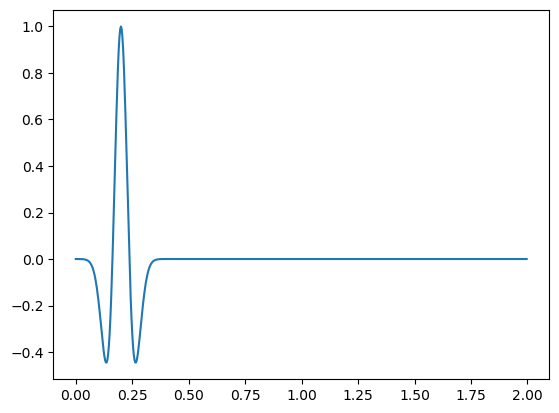

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f328fcdfc90>

In [7]:
@everywhere begin
    Nx = 101
    Ny = 101
#     c_true = ones(Nx,Ny)
    c_true = make_model(0.05, 51, Nx, Ny)
    rho = ones(Nx,Ny)
    h = 0.01

    # time
    Fs = 300;
    dt = 1/Fs;
    Nt = 600;
    t = range(0,length=Nt,step=dt);
    println("CFL: ", maximum(c_true) * dt / h);

    # source
    source = source_ricker(6,0.2,t)
    source_num = 1
    source_position = zeros(Int,source_num,2)
    for i = 1:source_num
            source_position[i,:] = [5 51]
    end
    source = repeat(source, 1, 1);

    # receiver
    receiver_num = 51
    receiver_position = zeros(Int,receiver_num,2)
    for i = 1:receiver_num
        receiver_position[i,:] = [1, (i-1)*2+1]
    end

    # PML
    pml_len = 50
    pml_coef = 50;
    
end
plot(t, source[:,1])

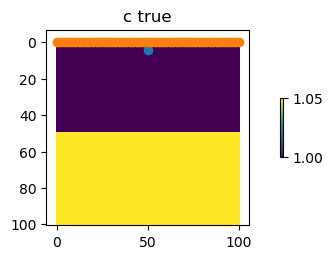

In [8]:
figure
# subplot(211); imshow(c, aspect=1.5); title("c"); colorbar(shrink=0.3); clim(2,5)
# scatter(source_position[:,2].-1, source_position[:,1].-1)
# scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

subplot(212); imshow(c_true); title("c true"); colorbar(shrink=0.3);
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

tight_layout()

In [9]:
@time uu, received_data = acoustic_solver(c_true, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);

  3.161401 seconds (7.00 M allocations: 382.190 MiB, 9.75% gc time)


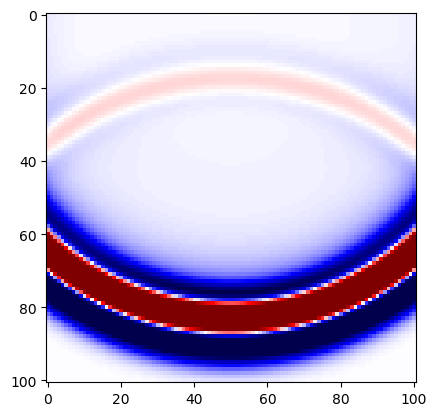

In [10]:
wv = uu[:,:,300]
imshow(wv, cmap="seismic"); clim(-1e-1,1e-1)

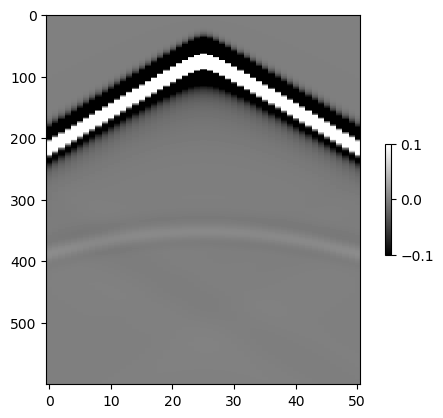

In [11]:
imshow(received_data[:,:], cmap="gray", aspect=0.1); colorbar(shrink=0.3);
clim([-1e-1,1e-1]);

In [12]:
delta_c = range(-0.1, step=0.01, stop=0.2)
num_delta_c = length(delta_c)
z = 40:60
num_z = length(z)

misfit_l2 = SharedArray{Float64}(num_delta_c, num_z)
misfit_ot1 = SharedArray{Float64}(num_delta_c, num_z)
misfit_ot2 = SharedArray{Float64}(num_delta_c, num_z)
misfit_ot3 = SharedArray{Float64}(num_delta_c, num_z);

In [13]:
i = 20
j = 1
cc = make_model(delta_c[i], z[j], Nx, Ny)
data = acoustic_solver_no_wavefield(cc, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);

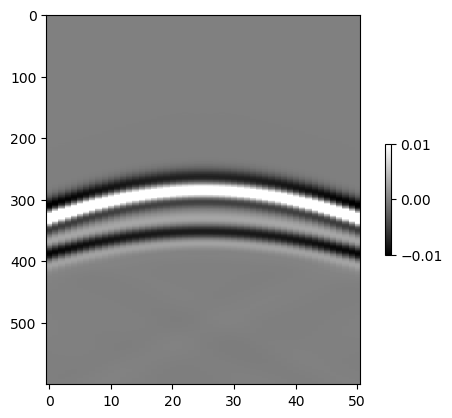

In [14]:
imshow(data-received_data, cmap="gray", aspect=0.1); colorbar(shrink=0.3);
clim([-1e-2,1e-2]);

In [15]:
maximum(data)

1.4240935126653376

In [16]:
0.5*norm(received_data-data,2)^2

0.14509881984624112

In [17]:
M = cost_matrix_1d(t,t)
reg = 1e-4
reg_m = 1e0
iterMax = 100
k1 = 0.05
k2 = 0.5
k3 = 100
@time dist, adj = adj_source_ot_exp(data, received_data, M; reg=reg, reg_m=reg_m, iterMax=iterMax, k=k2);

  3.533580 seconds (5.63 M allocations: 1.832 GiB, 10.16% gc time)


In [18]:
dist

8.069678506177706

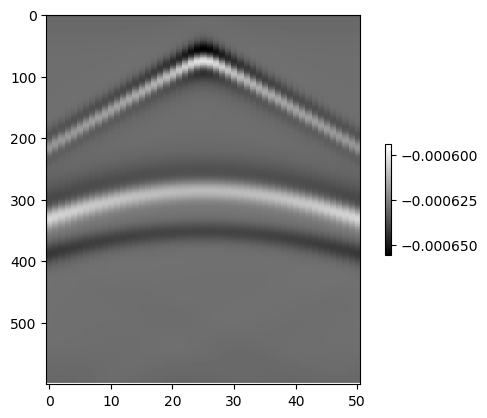

In [19]:
imshow(adj, cmap="gray", aspect=0.1); colorbar(shrink=0.3);
# clim([-1e-2,1e-2]);

In [20]:
num_delta_c

31

In [21]:
@time @sync @distributed for i = 1:num_delta_c
    for j = 1:num_z
        cc = make_model(delta_c[i], z[j], Nx, Ny)
        
        data = acoustic_solver_no_wavefield(cc, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);
        
        dist1, adj = adj_source_ot_exp(data, received_data, M; reg=reg, reg_m=reg_m, iterMax=iterMax, k=k1);
        dist2, adj = adj_source_ot_exp(data, received_data, M; reg=reg, reg_m=reg_m, iterMax=iterMax, k=k2);
        dist3, adj = adj_source_ot_exp(data, received_data, M; reg=reg, reg_m=reg_m, iterMax=iterMax, k=k3);
        adj = nothing
        
        misfit_l2[i,j] = 0.5*norm(received_data-data,2)^2
        misfit_ot1[i,j] = dist1
        misfit_ot2[i,j] = dist2
        misfit_ot3[i,j] = dist3
    end
    println(i/num_delta_c)
end
misfit_l2 = Array(misfit_l2)
misfit_ot1 = Array(misfit_ot1)
misfit_ot2 = Array(misfit_ot2)
misfit_ot3 = Array(misfit_ot3);

      From worker 7:	0.1935483870967742
      From worker 27:	0.8387096774193549
      From worker 31:	0.967741935483871
      From worker 32:	1.0
      From worker 17:	0.5161290322580645
      From worker 25:	0.7741935483870968
      From worker 2:	0.03225806451612903
      From worker 12:	0.3548387096774194
      From worker 6:	0.16129032258064516
      From worker 9:	0.25806451612903225
      From worker 21:	0.6451612903225806
      From worker 28:	0.8709677419354839
      From worker 20:	0.6129032258064516
      From worker 26:	0.8064516129032258
      From worker 30:	0.9354838709677419
      From worker 19:	0.5806451612903226
      From worker 8:	0.22580645161290322
      From worker 5:	0.12903225806451613
      From worker 18:	0.5483870967741935
      From worker 16:	0.4838709677419355
      From worker 15:	0.45161290322580644
      From worker 13:	0.3870967741935484
      From worker 14:	0.41935483870967744
      From worker 29:	0.9032258064516129
      From worker 23:	0.7096774

In [22]:
@save "result4.jld2" misfit_l2 misfit_ot1 misfit_ot2 misfit_ot3 delta_c z k1 k2 k3

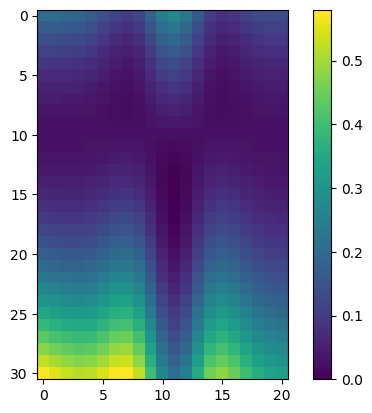

PyObject <matplotlib.colorbar.Colorbar object at 0x7f326411de10>

In [23]:
imshow(misfit_l2); colorbar()

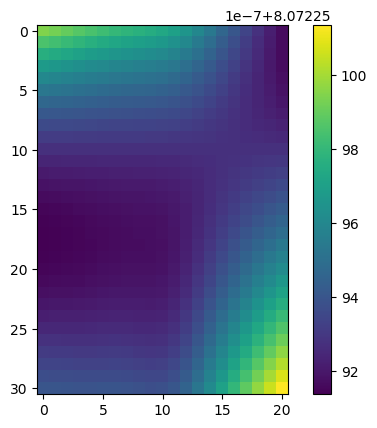

PyObject <matplotlib.colorbar.Colorbar object at 0x7f3264057d50>

In [24]:
imshow(misfit_ot1); colorbar()

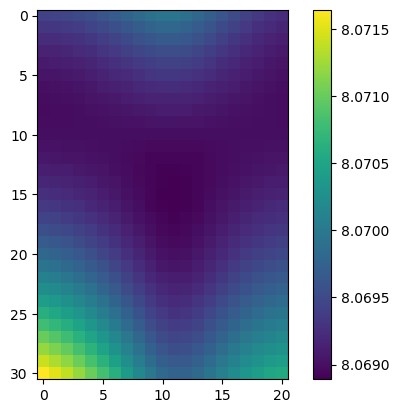

PyObject <matplotlib.colorbar.Colorbar object at 0x7f3240774810>

In [25]:
imshow(misfit_ot2); colorbar()

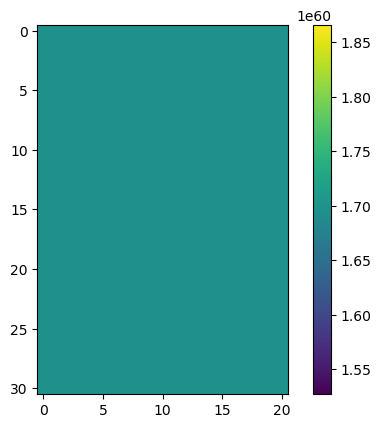

PyObject <matplotlib.colorbar.Colorbar object at 0x7f324072f7d0>

In [26]:
imshow(misfit_ot3); colorbar()